<a href="https://colab.research.google.com/github/yuri-val/rd-colaboratory/blob/lesson_3/notebooks/lesson_03/regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнє завдання – Заняття 3: Розробка та навчання нейронної мережі

## Мета
Розробити та навчити нейронну мережу для класифікації або регресії на новому наборі даних, використовуючи методи регуляризації для покращення продуктивності моделі та запобігання перенавчанню.

---

## Кроки для виконання завдання

### 1. Завантаження та попередня обробка даних
- Завантажте набір даних і перевірте його на:
  - Пропущені значення.
  - Аномалії.
  - Некоректні типи даних.
- Виконайте нормалізацію або стандартизацію числових ознак.
- Розділіть дані на:
  - Навчальну вибірку.
  - Тестову вибірку.
  - (За необхідності) Валідаційну вибірку для налаштування гіперпараметрів.

---

### 2. Створення архітектури нейронної мережі
- Розробіть архітектуру з кількома прихованими шарами, використовуючи функцію активації ReLU або іншу, залежно від задачі.
- Налаштуйте вихідний шар:
  - Для класифікації: softmax або sigmoid.
  - Для регресії: один нейрон із лінійною активацією.

---

### 3. Додавання методів регуляризації
- **L2 регуляризація:** Додайте штрафні коефіцієнти до ваг моделі для запобігання перенавчанню.
- **Dropout:** Використовуйте між прихованими шарами для випадкового вимикання нейронів під час навчання.
- **Batch Normalization:** Застосуйте для покращення збіжності та стабільності роботи моделі.

---

### 4. Налаштування параметрів навчання
- Використовуйте оптимальні значення гіперпараметрів, отримані в попередніх завданнях.

---

### 5. Навчання моделі з регуляризацією
- Зосередьтеся на уникненні перенавчання, спостерігаючи за результатами на валідаційній вибірці.

---

### 6. Оцінка продуктивності моделі
- Обчисліть метрики точності або середньоквадратичної помилки.
- Перевірте різницю між навчальною та валідаційною вибірками для виявлення перенавчання.
- Побудуйте:
  - Матрицю невідповідностей для класифікації.
  - Графіки оцінки продуктивності для регресійних моделей.

---

### 7. Візуалізація результатів
- Створіть графіки втрат і точності (для класифікації) або середньоквадратичної помилки (для регресії).
- Проаналізуйте вплив регуляризації на покращення роботи моделі.

---

## Мінімальні вимоги
- Реалізувати нейронну мережу та навчити її на новому наборі даних.
- Досягти стабільної роботи моделі із запобіганням перенавчанню через регуляризацію.
- Виконати базову візуалізацію втрат і продуктивності.

---

## Додаткові рекомендації
- Експериментуйте з гіперпараметрами регуляризації, такими як коефіцієнт L2 або ймовірність Dropout.
- Застосуйте **ранню зупинку (Early Stopping)**, щоб уникнути перенавчання.

---

## Формат виконання
- **.ipynb блокнот:** Код із візуалізацією.
- **.py файл:** Код із прикріпленими зображеннями результатів, опублікований на GitHub.


### Базова імплементація

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random


In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



100%|██████████| 170M/170M [00:02<00:00, 80.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:

class BaseNeuralNetWithRegularization(nn.Module):
    def __init__(self):
        super(BaseNeuralNetWithRegularization, self).__init__()

    def init_datasets(self, train_dataset=train_dataset, test_dataset=test_dataset):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    def init_loaders(self, train_loader=train_loader, test_loader=test_loader):
        self.train_loader = train_loader
        self.test_loader = test_loader

    def start_learning(self, epochs=10, lr=0.001, weight_decay=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses, test_losses = [], []

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0

            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            train_losses.append(running_loss / len(self.train_loader))

            self.eval()
            test_loss = 0.0
            correct = 0

            with torch.no_grad():
                for images, labels in self.test_loader:
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()

            test_losses.append(test_loss / len(self.test_loader))
            accuracy = correct / len(self.test_dataset)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")


        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.title('Train and Test Loss with Regularization')
        plt.show()

        self.eval()
        examples = iter(self.test_loader)
        images, labels = next(examples)

        with torch.no_grad():
            outputs = self(images)
            _, predictions = torch.max(outputs, 1)

        fig, axes = plt.subplots(1, 5, figsize=(15, 4))
        for i in range(5):
            index = random.randint(0, len(images) - 1)
            axes[i].imshow(images[index].permute(1, 2, 0))  # CIFAR-10 має 3 канали
            axes[i].set_title(f"True: {self.train_dataset.classes[labels[index]]}, Pred: {self.train_dataset.classes[predictions[index]]}")
            axes[i].axis('off')

        plt.show()

This model, `CIFARNeuralNetWithDropout`, is designed for classifying images from the CIFAR-10 dataset. Here are its key characteristics:

1. **Architecture**: It's a fully connected neural network with three linear layers (fc1, fc2, fc3).

2. **Input Layer**: The input layer (fc1) expects flattened images of size 32x32x3 (3072 neurons), which corresponds to the dimensions of CIFAR-10 images.

3. **Hidden Layers**:
   - The first hidden layer (fc1) has 512 neurons.
   - The second hidden layer (fc2) has 256 neurons.

4. **Output Layer**: The output layer (fc3) has 10 neurons, corresponding to the 10 classes in CIFAR-10.

5. **Activation Functions**:
   - ReLU (Rectified Linear Unit) is used after the first two linear layers.
   - LogSoftmax is applied to the output layer for multi-class classification.

6. **Regularization**:
   - Dropout is applied after the first two linear layers to prevent overfitting.
   - The dropout rate is configurable (default is 0.5).

7. **Forward Pass**:
   - The input is first flattened from a 2D image to a 1D vector.
   - The data then passes through the linear layers, with ReLU activations and dropout applied between them.
   - The final output is passed through a LogSoftmax function.

8. **Inheritance**: The model inherits from `BaseNeuralNetWithRegularization`, which likely provides common functionality for training and evaluation.

This model implements several best practices for deep learning:
- Use of dropout for regularization
- ReLU activation functions for non-linearity
- LogSoftmax for stable multi-class classification

It's a relatively simple model designed for the CIFAR-10 dataset, focusing on demonstrating the use of dropout regularization to combat overfitting in neural networks.

In [4]:
class CIFARNeuralNetWithDropout(BaseNeuralNetWithRegularization):
    def __init__(self, p_dropout=0.5):
        super(CIFARNeuralNetWithDropout, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)  # Регуляризація Dropout
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення 2D зображення в 1D
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        return x


Epoch 1/15, Train Loss: 1.9108, Test Loss: 1.8155, Accuracy: 0.3525
Epoch 2/15, Train Loss: 1.8694, Test Loss: 1.8038, Accuracy: 0.3567
Epoch 3/15, Train Loss: 1.8731, Test Loss: 1.7971, Accuracy: 0.3710
Epoch 4/15, Train Loss: 1.8727, Test Loss: 1.7909, Accuracy: 0.3578
Epoch 5/15, Train Loss: 1.8691, Test Loss: 1.7868, Accuracy: 0.3559
Epoch 6/15, Train Loss: 1.8716, Test Loss: 1.8011, Accuracy: 0.3543
Epoch 7/15, Train Loss: 1.8694, Test Loss: 1.7573, Accuracy: 0.3704
Epoch 8/15, Train Loss: 1.8730, Test Loss: 1.7932, Accuracy: 0.3562
Epoch 9/15, Train Loss: 1.8730, Test Loss: 1.7684, Accuracy: 0.3608
Epoch 10/15, Train Loss: 1.8703, Test Loss: 1.8006, Accuracy: 0.3572
Epoch 11/15, Train Loss: 1.8738, Test Loss: 1.8028, Accuracy: 0.3481
Epoch 12/15, Train Loss: 1.8729, Test Loss: 1.7727, Accuracy: 0.3594
Epoch 13/15, Train Loss: 1.8701, Test Loss: 1.8236, Accuracy: 0.3450
Epoch 14/15, Train Loss: 1.8695, Test Loss: 1.7766, Accuracy: 0.3552
Epoch 15/15, Train Loss: 1.8725, Test Loss:

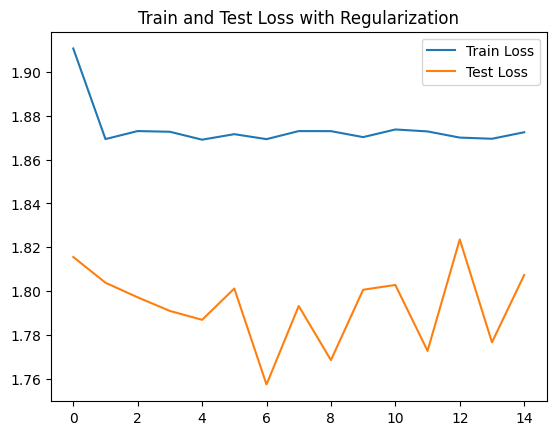

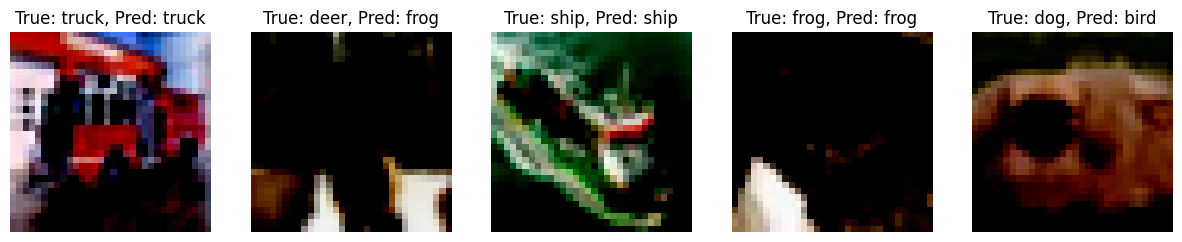

In [5]:
model = CIFARNeuralNetWithDropout()
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=15, lr=0.001, weight_decay=0.01)

Epoch 1/20, Train Loss: 1.8716, Test Loss: 1.6740, Accuracy: 0.4139
Epoch 2/20, Train Loss: 1.7084, Test Loss: 1.6046, Accuracy: 0.4412
Epoch 3/20, Train Loss: 1.6540, Test Loss: 1.5539, Accuracy: 0.4561
Epoch 4/20, Train Loss: 1.6250, Test Loss: 1.5391, Accuracy: 0.4635
Epoch 5/20, Train Loss: 1.5983, Test Loss: 1.5205, Accuracy: 0.4681
Epoch 6/20, Train Loss: 1.5849, Test Loss: 1.5125, Accuracy: 0.4703
Epoch 7/20, Train Loss: 1.5712, Test Loss: 1.5009, Accuracy: 0.4773
Epoch 8/20, Train Loss: 1.5587, Test Loss: 1.4910, Accuracy: 0.4796
Epoch 9/20, Train Loss: 1.5533, Test Loss: 1.4774, Accuracy: 0.4874
Epoch 10/20, Train Loss: 1.5447, Test Loss: 1.4711, Accuracy: 0.4900
Epoch 11/20, Train Loss: 1.5390, Test Loss: 1.4634, Accuracy: 0.4923
Epoch 12/20, Train Loss: 1.5355, Test Loss: 1.4588, Accuracy: 0.4941
Epoch 13/20, Train Loss: 1.5257, Test Loss: 1.4668, Accuracy: 0.4849
Epoch 14/20, Train Loss: 1.5255, Test Loss: 1.4565, Accuracy: 0.4941
Epoch 15/20, Train Loss: 1.5210, Test Loss:

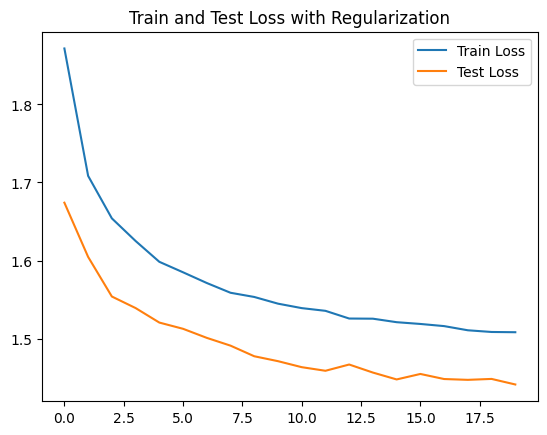

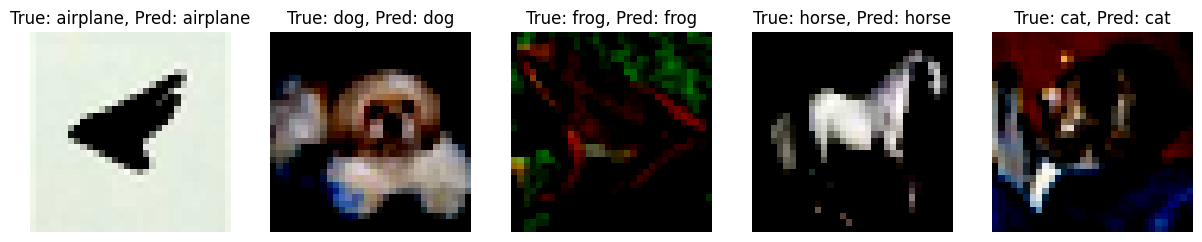

In [6]:
model = CIFARNeuralNetWithDropout()
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=20, lr=0.0001, weight_decay=0.01)

Description of the `EnhancedCIFARNet` model:

1. **Architecture**:
   - This is a Convolutional Neural Network (CNN) with three convolutional layers followed by two fully connected layers.
   - It inherits from `BaseNeuralNetWithRegularization`, likely providing common functionality for training and evaluation.

2. **Convolutional Layers**:
   - Conv1: 3 input channels (RGB) to 32 output channels
   - Conv2: 32 input channels to 64 output channels
   - Conv3: 64 input channels to 128 output channels
   - All convolutions use a 3x3 kernel with padding=1 to maintain spatial dimensions

3. **Fully Connected Layers**:
   - FC1: 128 * 4 * 4 (2048) input features to 256 output features
   - FC2: 256 input features to 10 output features (CIFAR-10 classes)

4. **Activation Functions**:
   - ReLU is used after each convolutional and the first fully connected layer
   - LogSoftmax is applied to the final output for multi-class classification

5. **Regularization Techniques**:
   - Dropout: Applied after the first fully connected layer with a configurable rate (default 0.3)
   - Batch Normalization: Applied after each convolutional layer
   - The model inherits from a base class that likely implements L2 regularization (weight decay)

6. **Pooling**:
   - Max pooling with a 2x2 kernel is applied after each convolutional layer

7. **Forward Pass**:
   - The input passes through three blocks of: Convolution -> Batch Norm -> ReLU -> Max Pool
   - The resulting feature map is flattened to 1D
   - It then goes through a fully connected layer with ReLU and dropout
   - Finally, it passes through the last fully connected layer and LogSoftmax

8. **Input and Output**:
   - Input: Expects 32x32x3 images (CIFAR-10 format)
   - Output: 10-dimensional vector representing class probabilities

This model incorporates several advanced techniques for improving performance and preventing overfitting:
- Use of convolutional layers for feature extraction
- Batch normalization for faster convergence and stability
- Dropout for regularization
- Max pooling for spatial dimension reduction
- A combination of CNN and fully connected layers

Compared to the previous `CIFARNeuralNetWithDropout` model, this `EnhancedCIFARNet` is more sophisticated and likely to perform better on the CIFAR-10 dataset due to its use of convolutional layers and additional regularization techniques.

In [7]:
class EnhancedCIFARNet(BaseNeuralNetWithRegularization):
  def __init__(self, p_dropout=0.3):
      super(EnhancedCIFARNet, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(128 * 4 * 4, 256)
      self.fc2 = nn.Linear(256, 10)
      self.relu = nn.ReLU()
      self.dropout = nn.Dropout(p=p_dropout)
      self.batch_norm1 = nn.BatchNorm2d(32)
      self.batch_norm2 = nn.BatchNorm2d(64)
      self.batch_norm3 = nn.BatchNorm2d(128)
      self.softmax = nn.LogSoftmax(dim=1)
      self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
      x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
      x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
      x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
      x = x.view(-1, 128 * 4 * 4)  # Перетворення в 1D
      x = self.dropout(self.relu(self.fc1(x)))
      x = self.softmax(self.fc2(x))
      return x

Epoch 1/25, Train Loss: 1.4156, Test Loss: 1.1113, Accuracy: 0.6108
Epoch 2/25, Train Loss: 1.0437, Test Loss: 0.9495, Accuracy: 0.6675
Epoch 3/25, Train Loss: 0.9122, Test Loss: 0.8891, Accuracy: 0.6883
Epoch 4/25, Train Loss: 0.8234, Test Loss: 0.8762, Accuracy: 0.7020
Epoch 5/25, Train Loss: 0.7604, Test Loss: 0.7904, Accuracy: 0.7278
Epoch 6/25, Train Loss: 0.7034, Test Loss: 0.7742, Accuracy: 0.7317
Epoch 7/25, Train Loss: 0.6599, Test Loss: 0.7620, Accuracy: 0.7326
Epoch 8/25, Train Loss: 0.6133, Test Loss: 0.7489, Accuracy: 0.7375
Epoch 9/25, Train Loss: 0.5742, Test Loss: 0.7092, Accuracy: 0.7529
Epoch 10/25, Train Loss: 0.5397, Test Loss: 0.7356, Accuracy: 0.7437
Epoch 11/25, Train Loss: 0.5056, Test Loss: 0.6969, Accuracy: 0.7553
Epoch 12/25, Train Loss: 0.4748, Test Loss: 0.6924, Accuracy: 0.7596
Epoch 13/25, Train Loss: 0.4434, Test Loss: 0.7090, Accuracy: 0.7574
Epoch 14/25, Train Loss: 0.4161, Test Loss: 0.6940, Accuracy: 0.7598
Epoch 15/25, Train Loss: 0.3875, Test Loss:

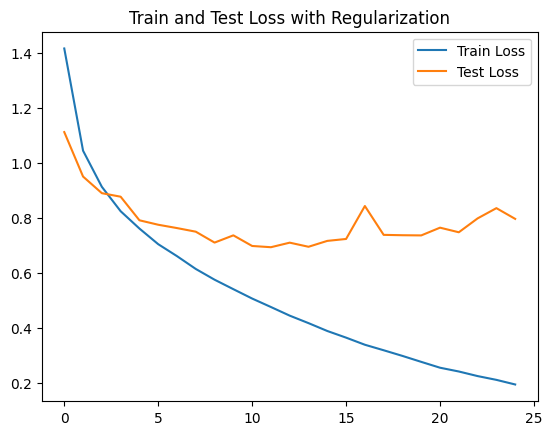

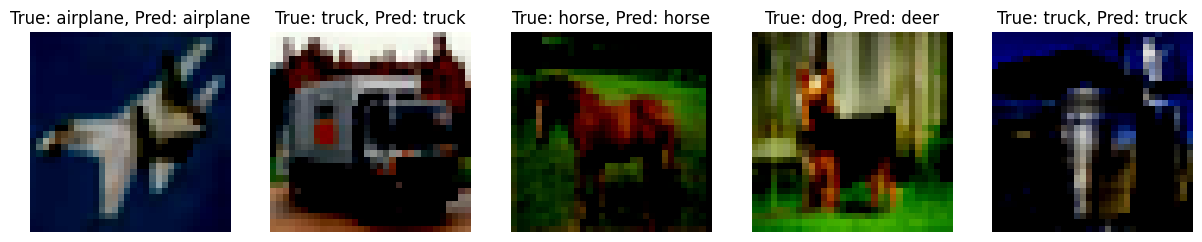

In [8]:
model = EnhancedCIFARNet(p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=25, lr=0.0001, weight_decay=0.001)

### Покращення для моделі

#### 1. Рання зупинка (Early Stopping)
Рання зупинка дозволить зупинити навчання, якщо тестова втрата перестає зменшуватися. Це допоможе уникнути перенавчання

Додамо механізм ранньої зупинки:

#### 2. Збільшення ширини та глибини моделі
Спробуємо збільшити кількість фільтрів у згорткових шарах:

In [7]:
class EnhancedCIFARNet(BaseNeuralNetWithRegularization):
    def __init__(self, p_dropout=0.3):
        super(EnhancedCIFARNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Додавання нормалізації та Dropout
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(p=p_dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        # Визначаємо розмірність після згорткових і пулингових шарів
        test_tensor = torch.zeros(1, 3, 32, 32)  # Подаємо фейковий вхід
        out = self.pool(self.relu(self.batch_norm1(self.conv1(test_tensor))))
        out = self.pool(self.relu(self.batch_norm2(self.conv2(out))))
        out = self.pool(self.relu(self.batch_norm3(self.conv3(out))))
        flatten_size = out.view(-1).shape[0]

        # Лінійні шари
        self.fc1 = nn.Linear(flatten_size, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.relu(self.batch_norm2(self.conv2(x))))
        x = self.pool(self.relu(self.batch_norm3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Перетворення в 1D
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.softmax(self.fc2(x))
        return x


In [8]:
model = EnhancedCIFARNet(p_dropout=0.3)
model.init_datasets(train_dataset=train_dataset, test_dataset=test_dataset)
model.init_loaders(train_loader=train_loader, test_loader=test_loader)
model.start_learning(epochs=25, lr=0.0001, weight_decay=0.001)

Epoch 1/25, Train Loss: 1.2785, Test Loss: 0.9906, Accuracy: 0.6539
Epoch 2/25, Train Loss: 0.9212, Test Loss: 0.8623, Accuracy: 0.7001
Epoch 3/25, Train Loss: 0.7867, Test Loss: 0.7881, Accuracy: 0.7204
Epoch 4/25, Train Loss: 0.6869, Test Loss: 0.7371, Accuracy: 0.7426
Epoch 5/25, Train Loss: 0.6069, Test Loss: 0.7181, Accuracy: 0.7520
Epoch 6/25, Train Loss: 0.5417, Test Loss: 0.6943, Accuracy: 0.7622
Epoch 7/25, Train Loss: 0.4810, Test Loss: 0.7107, Accuracy: 0.7594
Epoch 8/25, Train Loss: 0.4265, Test Loss: 0.6706, Accuracy: 0.7714
Epoch 9/25, Train Loss: 0.3746, Test Loss: 0.6949, Accuracy: 0.7725
Epoch 10/25, Train Loss: 0.3245, Test Loss: 0.6841, Accuracy: 0.7705
Epoch 11/25, Train Loss: 0.2836, Test Loss: 0.6841, Accuracy: 0.7848
Epoch 12/25, Train Loss: 0.2417, Test Loss: 0.6955, Accuracy: 0.7786
Epoch 13/25, Train Loss: 0.2056, Test Loss: 0.7583, Accuracy: 0.7665
Epoch 14/25, Train Loss: 0.1789, Test Loss: 0.7529, Accuracy: 0.7724
Epoch 15/25, Train Loss: 0.1563, Test Loss:

KeyboardInterrupt: 